In [177]:
""" Import Statements """
import pandas as pd
import numpy as np
import seaborn as sns
import json
import pymongo
import matplotlib.pyplot as plt


In [ ]:
def parse_relevant_data(data):
    """
        Parses the relevant data from the JSON file and returns a list of dictionaries.
        
        Parameters:
        data (dict): The JSON data loaded into a dictionary.
        
        Returns:
        list: A list of dictionaries containing the relevant data.
    """    
    relevant_data = []
    
    for game in data:
        game_data = data[game]
        relevant_data.append({
            'name': game_data['name'],
            'release_date': game_data['release_date'],
            'required_age': game_data['required_age'],
            'price': game_data['price'],
            'dlc_count': game_data['dlc_count'],
            'detailed_description': game_data['detailed_description'],
            'about_the_game': game_data['about_the_game'],
            'short_description': game_data['short_description'],
            'windows': game_data['windows'],
            'mac': game_data['mac'],
            'linux': game_data['linux'],
            'metacritic_score': game_data['metacritic_score'],
            'achievements': game_data['achievements'],
            'recommendations': game_data['recommendations'],
            'supported_languages': game_data['supported_languages'], 
            'full_audio_languages': game_data['full_audio_languages'], 
            'developers': game_data['developers'], 
            'developers': game_data['developers'], 
            'categories': game_data['categories'], 
            'genres': game_data['genres'], 
            'tags': game_data['tags'], 
            'positive_reviews': game_data['positive_reviews'],
            'score_rank': game_data['score_rank'],
            'positive_reviews': game_data['positive'],
            'negative_reviews': game_data['negative'],
            'estimated_owners': game_data['estimated_owners'],
            'average_playtime_forever': game_data['average_playtime_forever'],
            'average_playtime_2weeks': game_data['average_playtime_2weeks'],
            'median_playtime_forever': game_data['median_playtime_forever'],
            'median_playtime_2weeks': game_data['median_playtime_2weeks'],
            'peak_ccu': game_data['peak_ccu'],
        })
        
    return relevant_data

In [28]:
def load_dataset_into_mongodb(json_file, client_url, db_name, collection_name):
    """
        Loads the dataset from the json file and stores it into a MongoDB database.
        
        Parameters:
        json_file (str): Path to the JSON file.
        client_url (str): MongoDB client URL.
        db_name (str): Name of the database.
        collection_name (str): Name of the collection.
        
    """

    # Open the JSON file and load the data into a dictionary
    with open(json_file, encoding="utf8") as data_file:    
        data_dict = json.load(data_file)
    
    # Parse the relevant data from the dictionary
    relevant_data = parse_relevant_data(data_dict)
    
    # Create a local database
    client = pymongo.MongoClient(client_url)
    db = client[db_name]
    collection = db[collection_name]
    
    print("Database Names: ", client.list_database_names())
    print("games_database collection Names: ", db.list_collection_names())
    
    # If the database exists, create it. Otherwise, leave it alone    
    if collection.count_documents({}) > 0:
        print("The collection already has data.")
    else:
        collection.insert_many(relevant_data)
        print("The collection was populated with data.")
    
    client.close()

In [29]:
def pull_dataframe_from_mongodb(client_url, db_name, collection_name):
    """
    Pulls the collection from the MongoDB database and returns it as a DataFrame.

    Args:
        client_url (string): The URL of the MongoDB client
        db_name (string): The name of the database
        collection_name (string): The name of the collection

    Returns:
        _type_: _description_
    """
    # Access the local database
    client = pymongo.MongoClient(client_url)
    db = client[db_name]
    collection = db[collection_name]
    
    # If the database exists, pull the collection. Otherwise, leave it alone
    if collection_name in db.list_collection_names():
        print("The collection exists for retrieving data.")
        collection_data = collection.find()
    else:
        print("The collection does not exist.")
        collection_data = None
    
    # Convert the collection data to a DataFrame
    df = pd.DataFrame(list(collection_data))
    
    # Drop the '_id' column if it exists
    if '_id' in df.columns:
        df.drop(columns=['_id'], inplace=True)
    
    client.close()
    
    return df

In [110]:
def plot_scatterplot(data, x_column, y_column):
    new_df = data[[x_column, y_column]]

    plt.scatter(new_df[x_column], new_df[y_column])

    meanx = new_df[x_column].mean()
    meany = new_df[y_column].mean()
    plt.axvline(meanx, color='r', linestyle='--', label='Mean of X')
    plt.axhline(meany, color='g', linestyle='--', label='Mean of Y')

    plt.xlabel(x_column)
    plt.ylabel('Positive Reviews')
    plt.title(f'Scatter plot of {x_column} vs {y_column} (All Values)')

    # Add legend
    plt.legend()
    plt.show()
    plt.close()

def plot_scatterplot_without_extremes(data, x_column, y_column, x_extreme, y_extreme):
    new_df = data[(data[x_column] < x_extreme) & (data[y_column] < y_extreme)]

    plt.scatter(new_df[x_column], new_df[y_column])

    meanx = new_df[x_column].mean()
    meany = new_df[y_column].mean()
    plt.axvline(meanx, color='r', linestyle='--', label='Mean of X')
    plt.axhline(meany, color='g', linestyle='--', label='Mean of Y')

    plt.xlabel(x_column)
    plt.ylabel('Positive Reviews')
    plt.title(f'Scatter plot of {x_column} vs {y_column} (without Extremes)\n{x_column} < {x_extreme} \n {y_column} < {y_extreme}')

    # Add legend
    plt.legend()
    plt.show()
    plt.close()

In [82]:
# Main function to load the dataset into MongoDB and pull it as a DataFrame

DATA_FILE = "games.json"
CLIENT_URL = "mongodb://localhost:27017/"
DB_NAME = "games_database"
COLLECTION_NAME = "games"

# Load the dataset into MongoDB
load_dataset_into_mongodb(DATA_FILE, CLIENT_URL, DB_NAME, COLLECTION_NAME)

data = pull_dataframe_from_mongodb(CLIENT_URL, DB_NAME, COLLECTION_NAME)

# Process Data Here

# Changes the required_age column to a boolean value if under 18 or not
data['required_age'] = np.where(data['required_age'] >= 18, 1, 0)
data.rename(columns={'required_age': 'over_18_required'}, inplace=True)

# Changes the range of estimated_owners to the high value of the range
data['estimated_owners'] = data['estimated_owners'].apply(lambda x: x.split('-')[1].strip() if '-' in x else x)
data['estimated_owners'] = data['estimated_owners'].astype(int)


print("\n", data.head())


Database Names:  ['admin', 'config', 'games_database', 'local', 'mydatabase']
games_database collection Names:  ['games']
The collection already has data.
The collection exists for retrieving data.

                     name  release_date  over_18_required  price  dlc_count  \
0       Galactic Bowling  Oct 21, 2008                 0  19.99          0   
1           Train Bandit  Oct 12, 2017                 0   0.99          0   
2           Jolt Project  Nov 17, 2021                 0   4.99          0   
3               Henosis™  Jul 23, 2020                 0   5.99          0   
4  Two Weeks in Painland   Feb 3, 2020                 0   0.00          0   

                                detailed_description  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   
3  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
4  ABOUT THE GAME Play as a hacker who has arrang..


Positive Reviews:
 count    9.741000e+04
mean     8.489366e+02
std      2.287011e+04
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      3.500000e+01
max      5.764420e+06
Name: positive_reviews, dtype: float64

Positive Reviews = 0:  32173
Positive Reviews > 0:  65237
Positive Reviews > 500000:  1
Positive Reviews < 500000:  97409


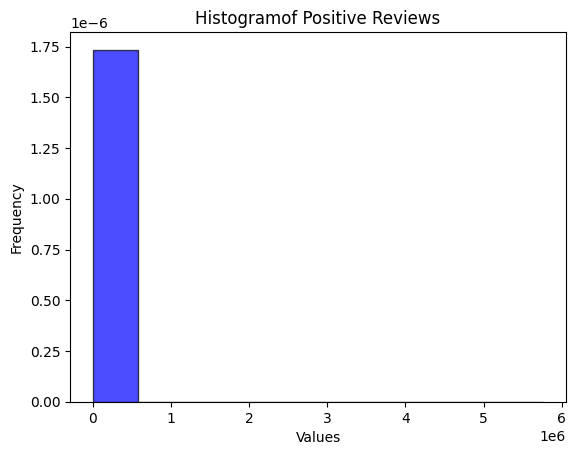

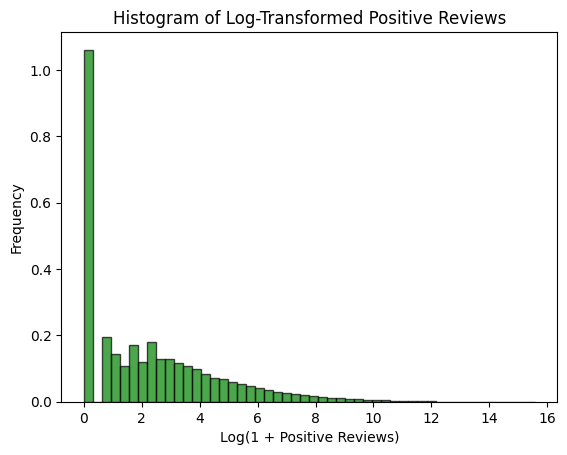

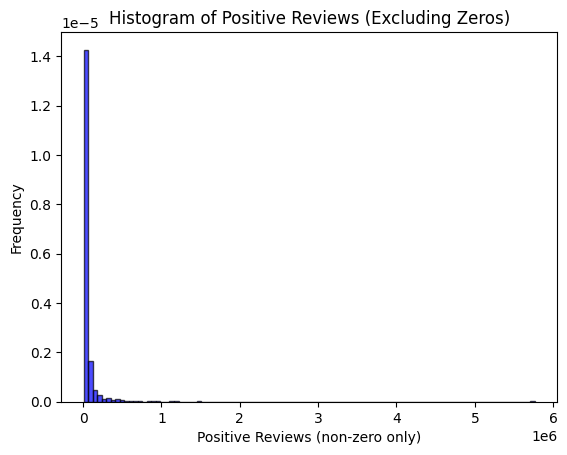

In [ ]:
# Some information about the positive reviews

print("\nPositive Reviews:\n", data['positive_reviews'].describe())

print("\nPositive Reviews = 0: ", data[data['positive_reviews'] == 0].shape[0])
print("Positive Reviews > 0: ", data[data['positive_reviews'] > 0].shape[0])
print("Positive Reviews > 500000: ", data[data['positive_reviews'] > 5000000].shape[0])
print("Positive Reviews < 500000: ", data[data['positive_reviews'] < 5000000].shape[0])

positive_reviews = pd.DataFrame({"positive_reviews":data['positive_reviews']})
plt.hist(positive_reviews['positive_reviews'], bins=10, density=True, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogramof Positive Reviews')
plt.show()

positive_reviews['log_positive_reviews'] = np.log1p(positive_reviews['positive_reviews'])

plt.hist(positive_reviews['log_positive_reviews'], bins=50, density=True, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Log(1 + Positive Reviews)')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Positive Reviews')
plt.show()

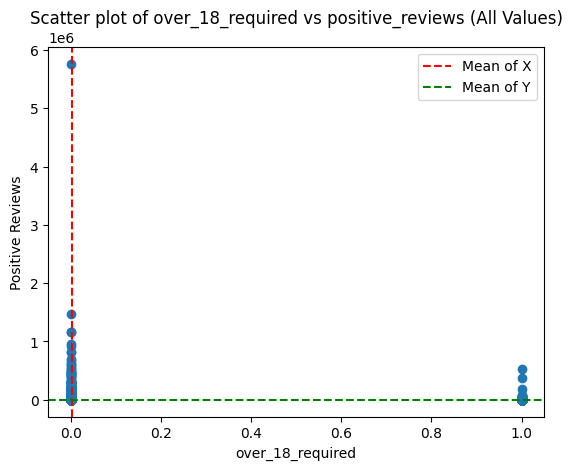

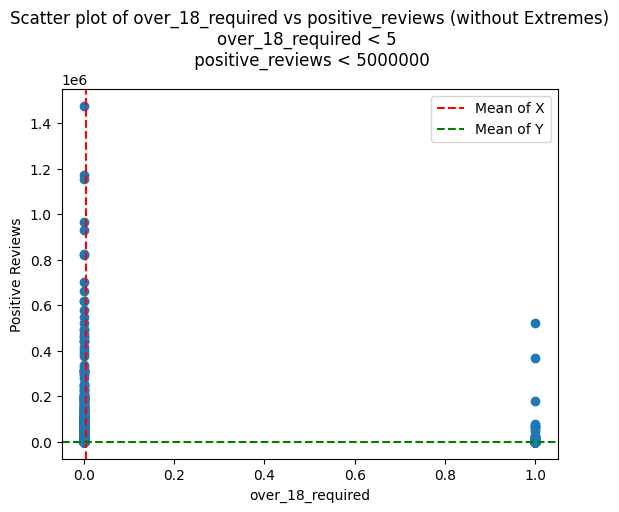

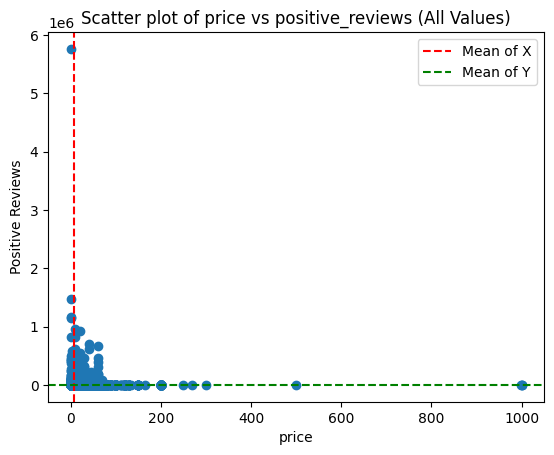

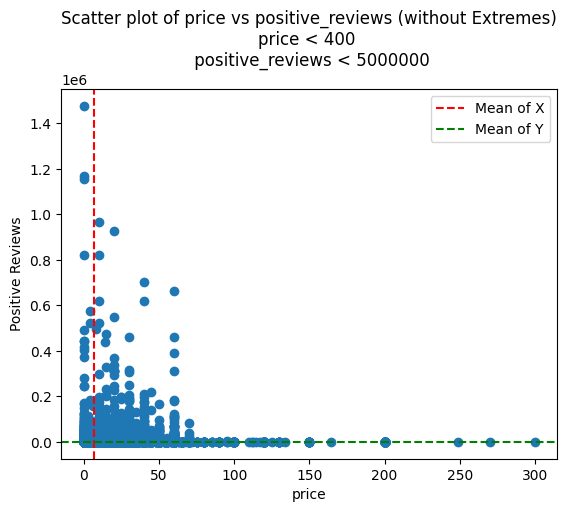

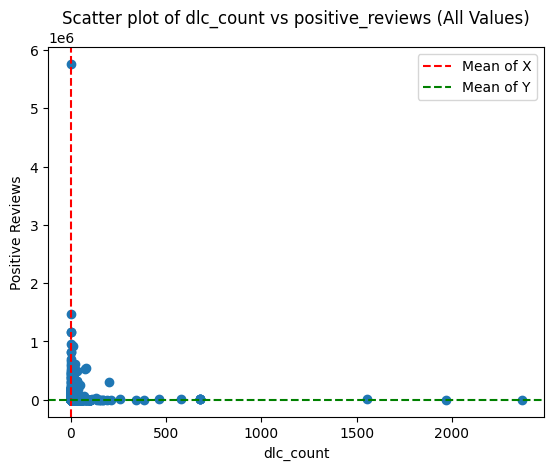

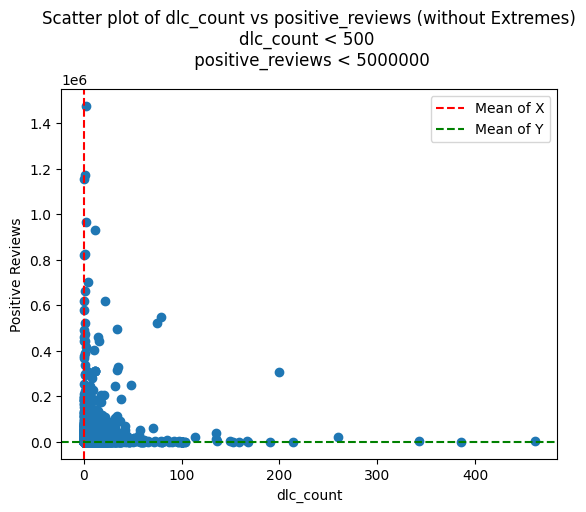

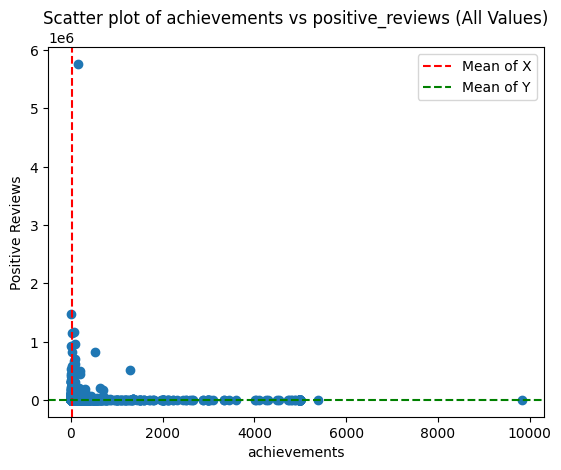

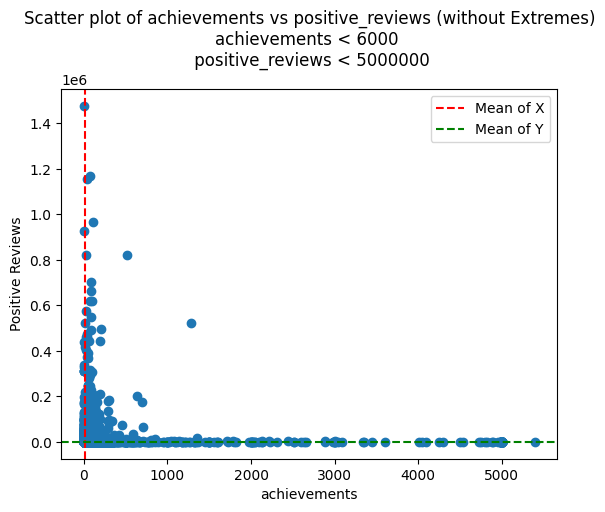

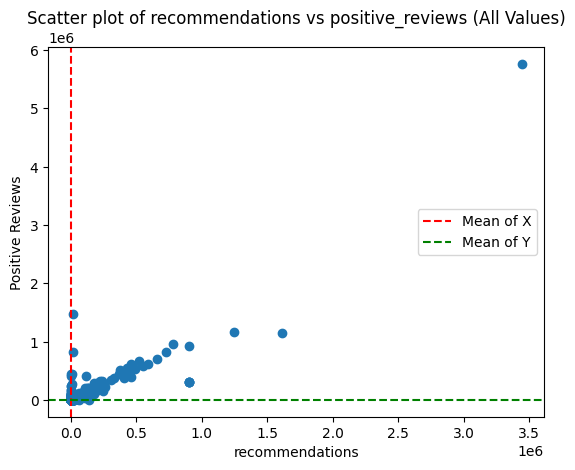

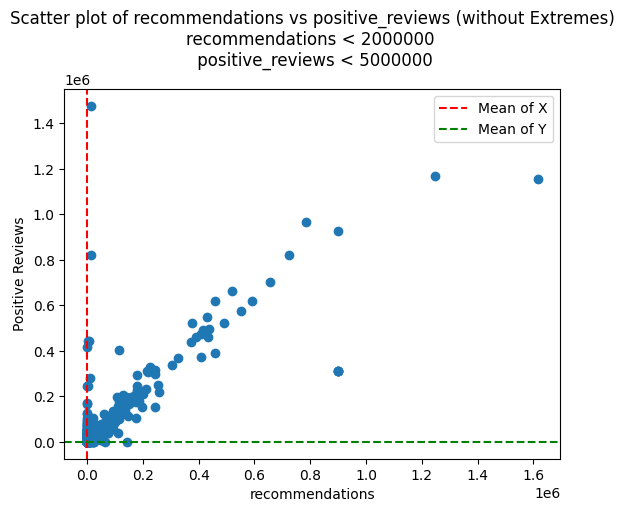

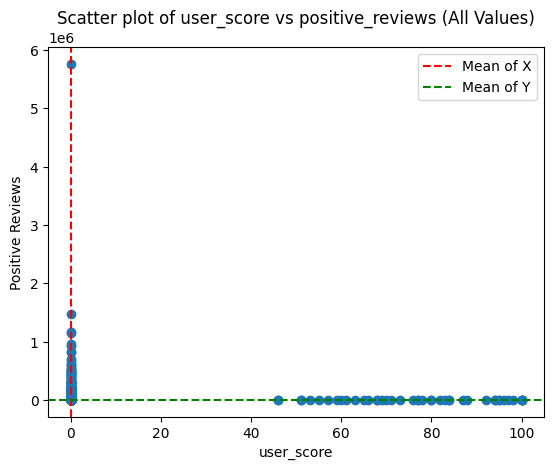

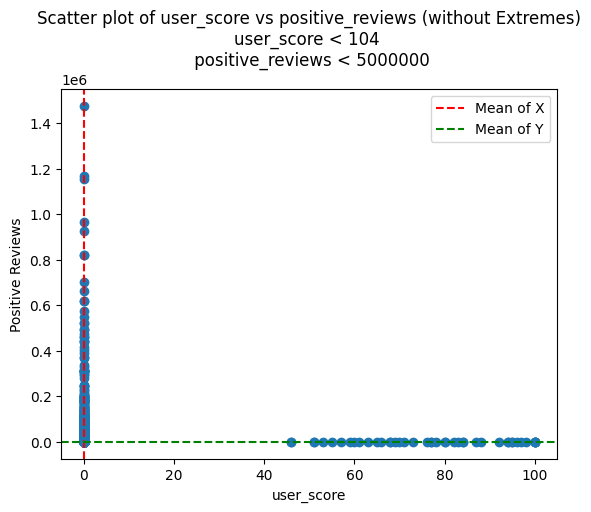

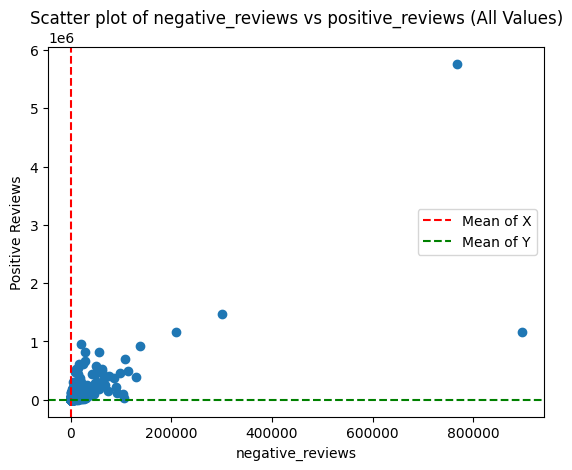

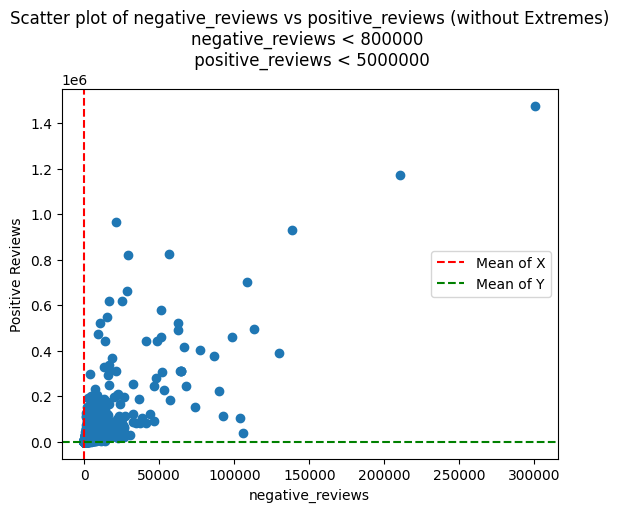

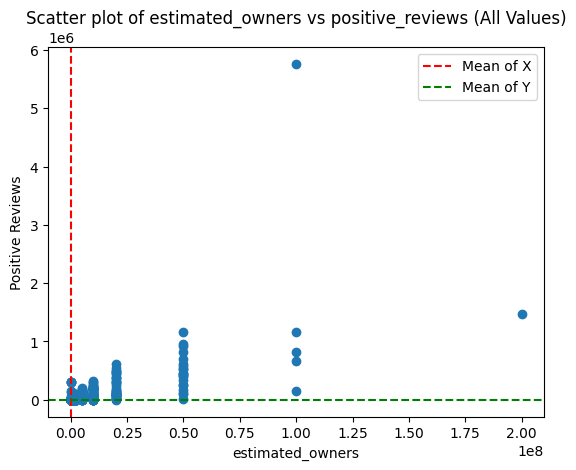

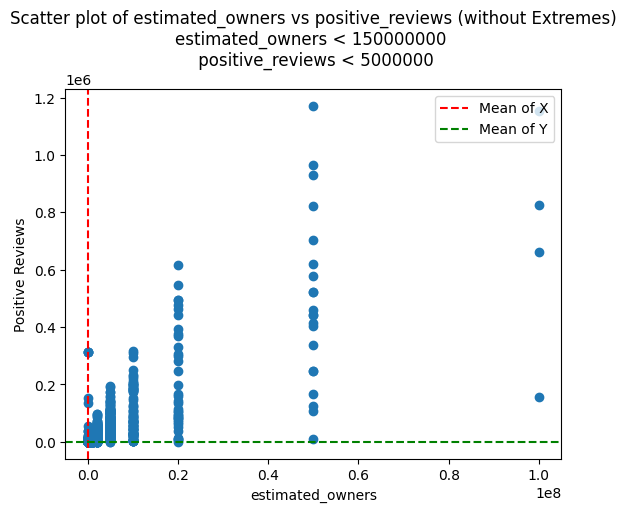

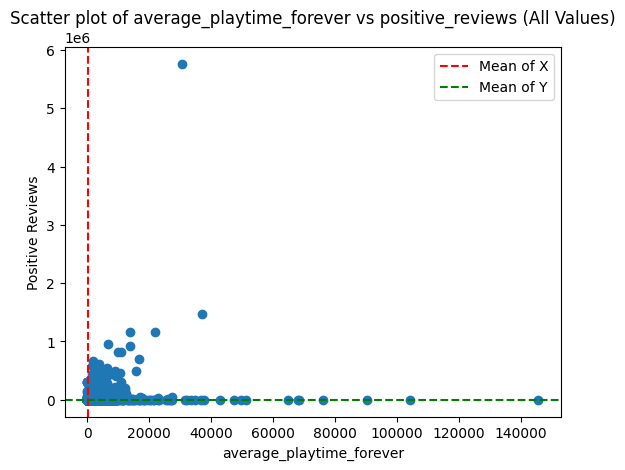

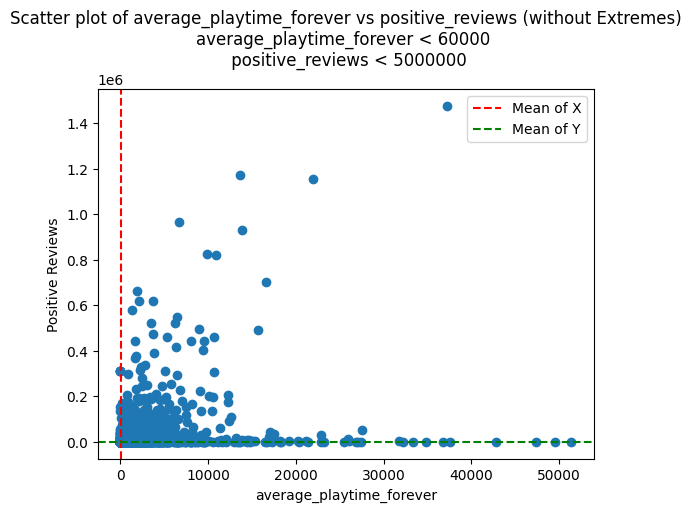

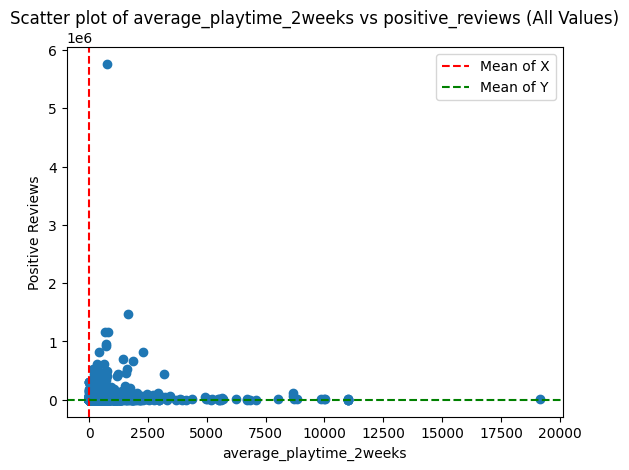

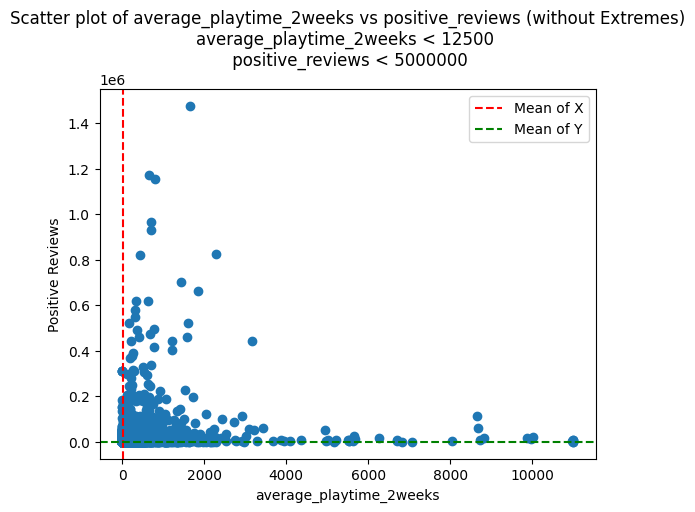

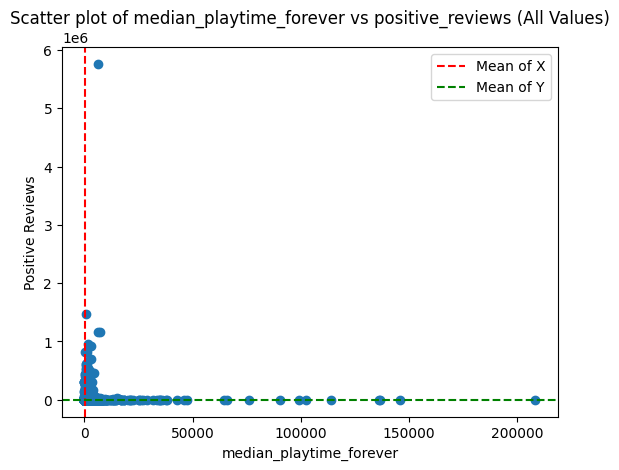

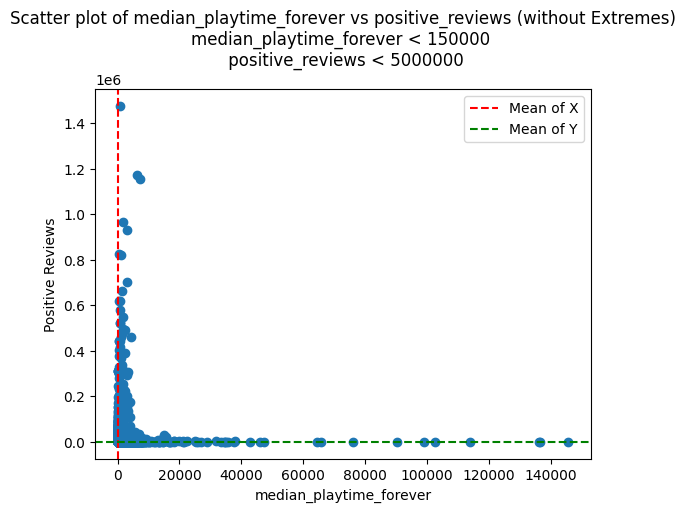

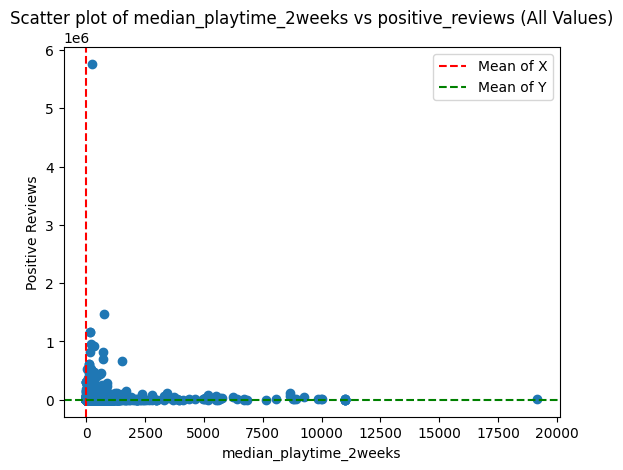

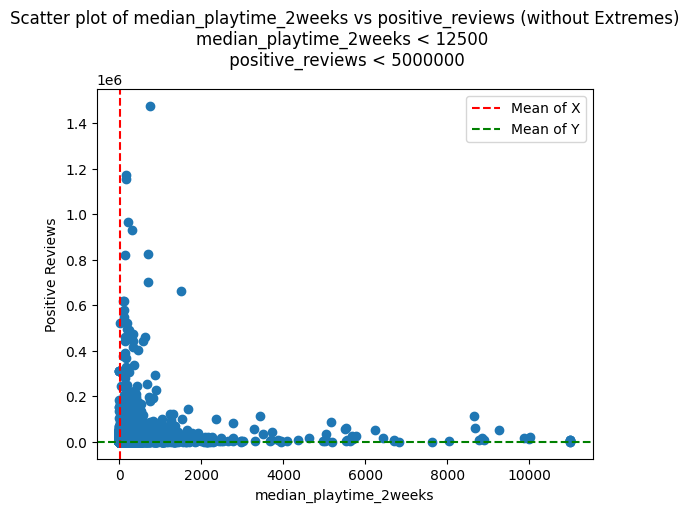

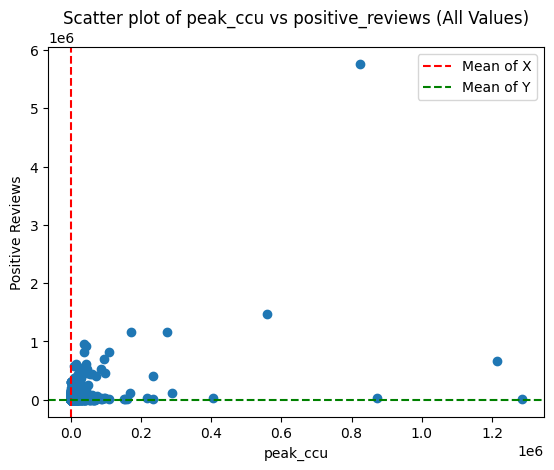

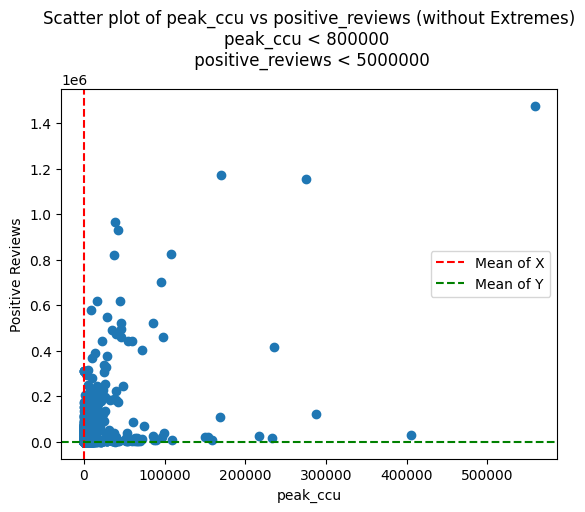

In [123]:
plot_scatterplot(data, "over_18_required", 'positive_reviews')
plot_scatterplot_without_extremes(data, "over_18_required", 'positive_reviews', 5, 5000000)

plot_scatterplot(data, "price", 'positive_reviews')
plot_scatterplot_without_extremes(data, "price", 'positive_reviews', 400, 5000000)

plot_scatterplot(data, "dlc_count", 'positive_reviews')
plot_scatterplot_without_extremes(data, "dlc_count", 'positive_reviews', 500, 5000000)

plot_scatterplot(data, "achievements", 'positive_reviews')
plot_scatterplot_without_extremes(data, "achievements", 'positive_reviews', 6000, 5000000)

plot_scatterplot(data, "recommendations", 'positive_reviews')
plot_scatterplot_without_extremes(data, "recommendations", 'positive_reviews', 2000000, 5000000)

plot_scatterplot(data, "user_score", 'positive_reviews')
plot_scatterplot_without_extremes(data, "user_score", 'positive_reviews', 104, 5000000)

plot_scatterplot(data, "negative_reviews", 'positive_reviews')
plot_scatterplot_without_extremes(data, "negative_reviews", 'positive_reviews', 800000, 5000000)

plot_scatterplot(data, "estimated_owners", 'positive_reviews')
plot_scatterplot_without_extremes(data, "estimated_owners", 'positive_reviews', 150000000, 5000000)

plot_scatterplot(data, "average_playtime_forever", 'positive_reviews')
plot_scatterplot_without_extremes(data, "average_playtime_forever", 'positive_reviews', 60000, 5000000)

plot_scatterplot(data, "average_playtime_2weeks", 'positive_reviews')
plot_scatterplot_without_extremes(data, "average_playtime_2weeks", 'positive_reviews', 12500, 5000000)

plot_scatterplot(data, "median_playtime_forever", 'positive_reviews')
plot_scatterplot_without_extremes(data, "median_playtime_forever", 'positive_reviews', 150000, 5000000)

plot_scatterplot(data, "median_playtime_2weeks", 'positive_reviews')
plot_scatterplot_without_extremes(data, "median_playtime_2weeks", 'positive_reviews', 12500, 5000000)

plot_scatterplot(data, "peak_ccu", 'positive_reviews')
plot_scatterplot_without_extremes(data, "peak_ccu", 'positive_reviews', 800000, 5000000)


Correlation of Tags with Positive Reviews:
 1980s                               -0.001966
1990's                              -0.002495
2.5D                                -0.001162
2D                                  -0.002528
2D Fighter                           0.000957
2D Platformer                       -0.005861
360 Video                           -0.000970
3D                                  -0.005969
3D Fighter                          -0.001083
3D Platformer                       -0.001193
3D Vision                            0.003588
4 Player Local                       0.002394
4X                                   0.005606
6DOF                                -0.002282
8-bit Music                         -0.000666
ATV                                 -0.000139
Abstract                            -0.003835
Action                               0.039242
Action RPG                           0.021689
Action RTS                          -0.001132
Action Roguelike                   

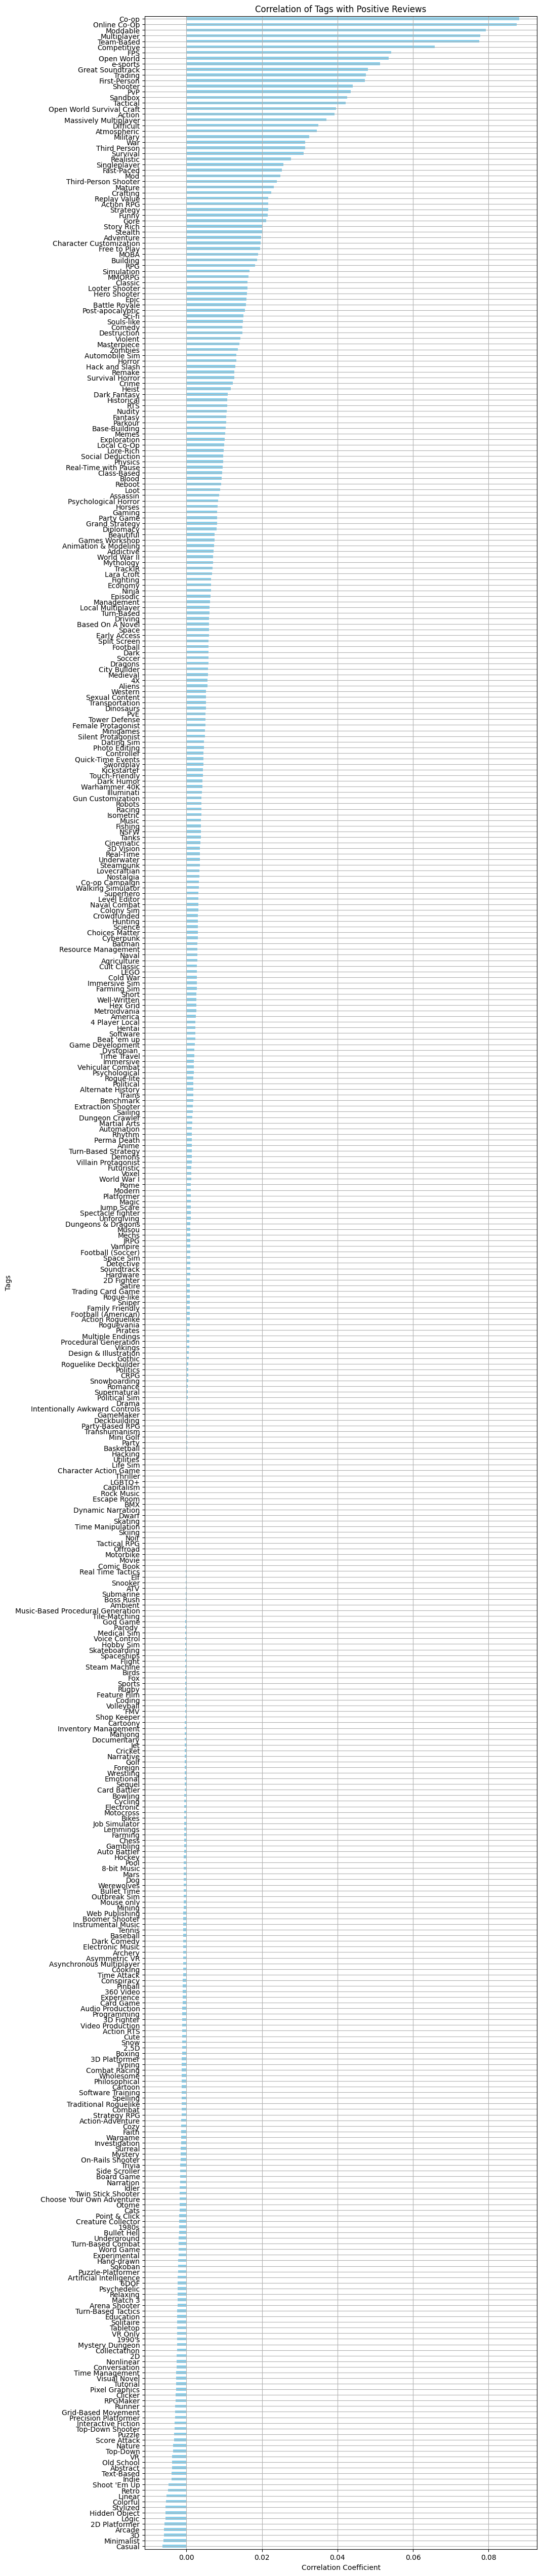

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

# One-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['tags'])

tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Combine with positive reviews
data_encoded = pd.concat([data[['positive_reviews']], tags_df], axis=1)

# Compute correlation with positive reviews
correlations = data_encoded.corr()['positive_reviews'].drop('positive_reviews')

print("\nCorrelation of Tags with Positive Reviews:\n", correlations.to_string())

# Sort and plot
plt.figure(figsize=(10, 75))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation of Tags with Positive Reviews')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Tags')
plt.grid(True)
plt.show()



Correlation of Categories with Positive Reviews:
 Captions available                   0.020175
Co-op                                0.043586
Commentary available                 0.020218
Cross-Platform Multiplayer           0.023300
Family Sharing                      -0.008736
Full controller support              0.028944
HDR available                        0.000370
In-App Purchases                     0.052837
Includes Source SDK                  0.026215
Includes level editor                0.026187
LAN Co-op                            0.022692
LAN PvP                              0.016961
MMO                                  0.014616
Mods                                 0.000921
Mods (require HL2)                   0.000524
Multi-player                         0.046672
Online Co-op                         0.047236
Online PvP                           0.035782
Partial Controller Support           0.010628
PvP                                  0.027890
Remote Play Together         

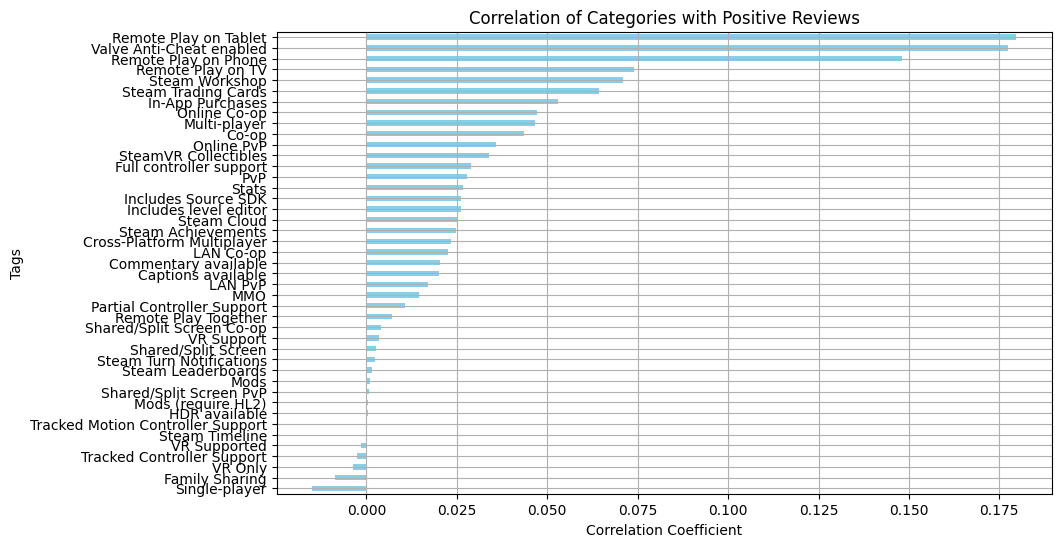

In [191]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

# One-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['categories'])

tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Combine with positive reviews
data_encoded = pd.concat([data[['positive_reviews']], tags_df], axis=1)

# Compute correlation with positive reviews
correlations = data_encoded.corr()['positive_reviews'].drop('positive_reviews')

print("\nCorrelation of Categories with Positive Reviews:\n", correlations.to_string())

# Sort and plot
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation of Categories with Positive Reviews')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Tags')
plt.grid(True)
plt.show()


Correlation of Genres with Positive Reviews:
 360 Video               -0.000119
Accounting              -0.000589
Action                   0.021893
Adventure               -0.000667
Animation & Modeling     0.001798
Audio Production        -0.001154
Casual                  -0.021580
Design & Illustration    0.001069
Documentary             -0.000119
Early Access            -0.007280
Education               -0.002302
Episodic                -0.000119
Free To Play            -0.002141
Free to Play             0.018616
Game Development        -0.001686
Gore                    -0.001786
Indie                   -0.021769
Massively Multiplayer    0.015352
Movie                   -0.000006
Nudity                  -0.001158
Photo Editing            0.004716
RPG                      0.006966
Racing                  -0.001786
Sexual Content          -0.001091
Short                   -0.000168
Simulation              -0.000673
Software Training       -0.001558
Sports                  -0.001743
S

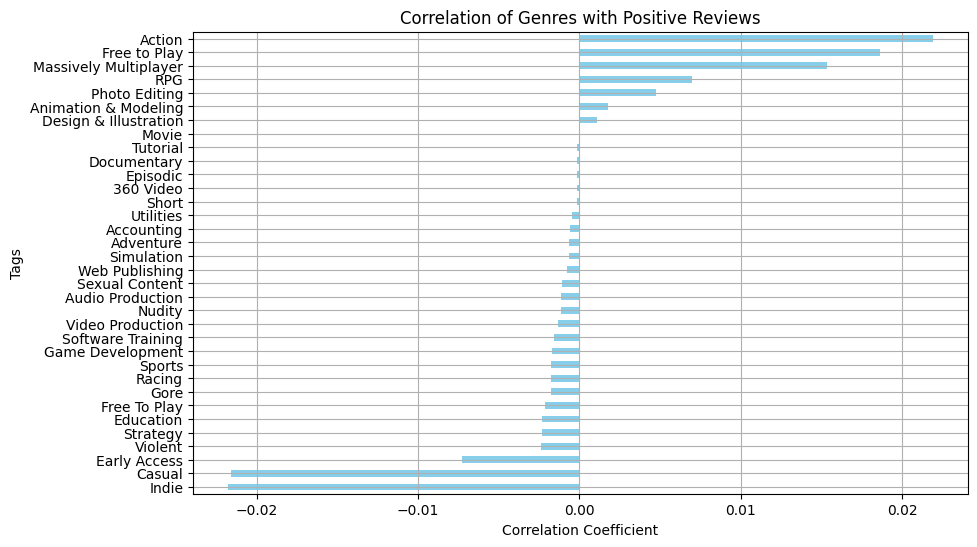

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

# One-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['genres'])

tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Combine with positive reviews
data_encoded = pd.concat([data[['positive_reviews']], tags_df], axis=1)

# Compute correlation with positive reviews
correlations = data_encoded.corr()['positive_reviews'].drop('positive_reviews')

print("\nCorrelation of Genres with Positive Reviews:\n", correlations.to_string())

# Sort and plot
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation of Genres with Positive Reviews')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Tags')
plt.grid(True)
plt.show()

Number of unique publishers: 49771

Correlation of the top 500 top_publishersPublishers with Positive Reviews:
                                                             -0.007557
072 Project                                                 -0.000631
0Cube                                                       -0.000448
101XP                                                       -0.000281
10tons Ltd                                                  -0.000225
2K                                                           0.022994
2P Games                                                    -0.000357
3D Realms (Apogee Software)                                 -0.000491
505 Games                                                    0.004251
7miao game                                                  -0.000518
8Floor                                                       0.000017
8floor                                                      -0.001941
ACG creator                                     

c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29611 (\N{CJK UNIFIED IDEOGRAPH-73AB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29808 (\N{CJK UNIFIED IDEOGRAPH-7470}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packa

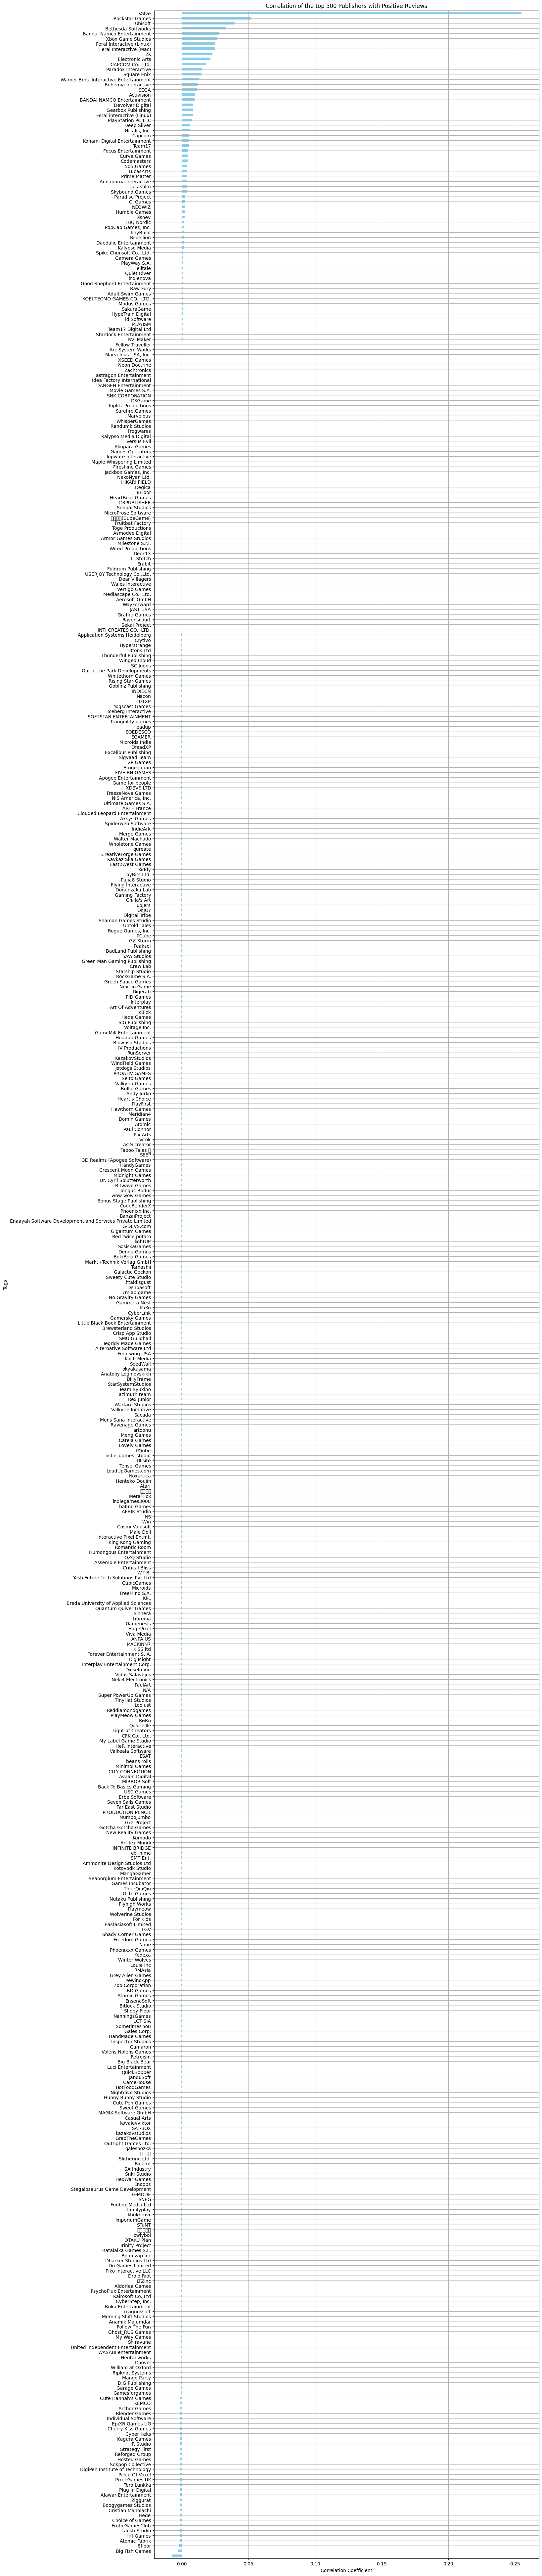

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

print(f"Number of unique developers: {data['publishers'].explode().nunique()}")
LIMIT = 500

top_publishers = data['publishers'].explode().value_counts().head(LIMIT).index
data['publishers_filtered'] = data['publishers'].apply(lambda x: [i for i in x if i in top_publishers])

# One-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['publishers_filtered'])

tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Combine with positive reviews
data_encoded = pd.concat([data[['positive_reviews']], tags_df], axis=1)

# Compute correlation with positive reviews
correlations = data_encoded.corr()['positive_reviews'].drop('positive_reviews')

# "Top" meaning the amount of games that the publisher has published
print(f"\nCorrelation of the top {LIMIT} Publishers with Positive Reviews:\n", correlations.to_string())

# Sort and plot
plt.figure(figsize=(15, LIMIT / 5))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title(f'Correlation of the top {LIMIT} Publishers with Positive Reviews')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Publisher')
plt.grid(True)
plt.show()

Number of unique developers: 60274

Correlation of the top 500 Developers with Positive Reviews:
 07th Expansion                                              -0.000100
10tons Ltd                                                  -0.000225
3dm_live_wallpapers                                         -0.000377
7miao game                                                  -0.000518
8floor                                                      -0.000682
A Nostru                                                    -0.000440
ACQUIRE Corp.                                               -0.000011
AFBIK Studio                                                -0.000518
AMAX Interactive                                            -0.000916
ATLUS                                                        0.002091
AVI Games                                                   -0.000460
Adamvision Studios                                          -0.000149
Airem                                                       -0

c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29611 (\N{CJK UNIFIED IDEOGRAPH-73AB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29808 (\N{CJK UNIFIED IDEOGRAPH-7470}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elija\GitHub\CAP4770-Final-Project\.venv\Lib\site-packa

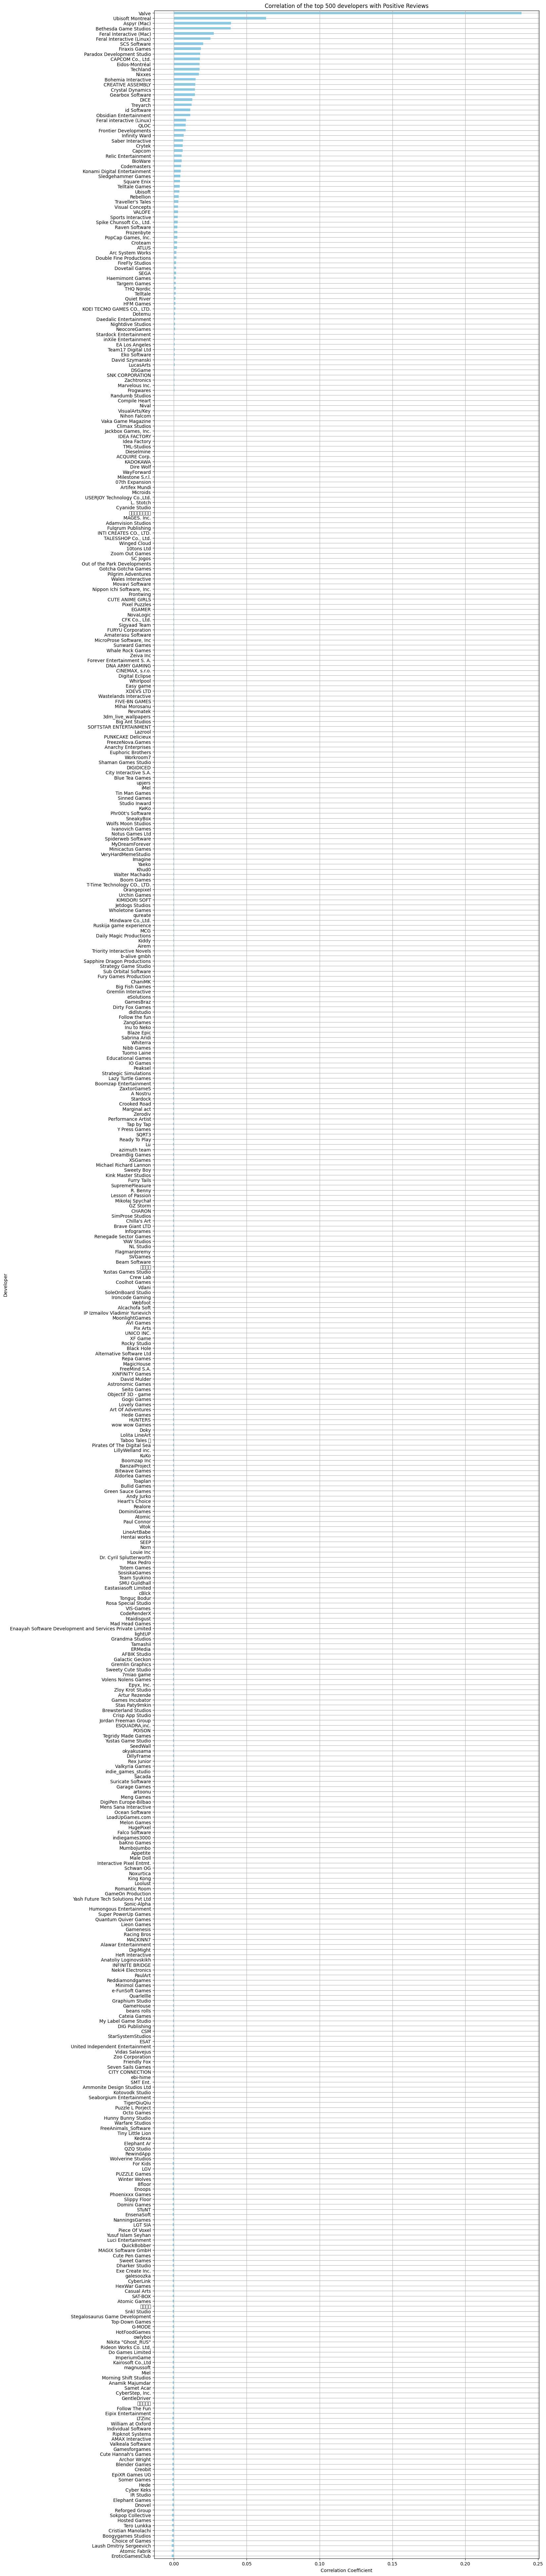

In [211]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

print(f"Number of unique developers: {data['developers'].explode().nunique()}")
LIMIT = 500

top_developers = data['developers'].explode().value_counts().head(LIMIT).index
data['developers_filtered'] = data['developers'].apply(lambda x: [i for i in x if i in top_developers])

# One-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['developers_filtered'])

tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Combine with positive reviews
data_encoded = pd.concat([data[['positive_reviews']], tags_df], axis=1)

# Compute correlation with positive reviews
correlations = data_encoded.corr()['positive_reviews'].drop('positive_reviews')

# "Top" meaning the amount of games that the publisher has published
print(f"\nCorrelation of the top {LIMIT} Developers with Positive Reviews:\n", correlations.to_string())

# Sort and plot
plt.figure(figsize=(15, LIMIT / 5))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title(f'Correlation of the top {LIMIT} developers with Positive Reviews')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Developer')
plt.grid(True)
plt.show()

Number of unique Supported Languages: 134

Correlation of the top 135 Supported Languages with Positive Reviews:
 \r\nFrench                                                                                        -0.000109
\r\nGerman                                                                                        -0.000109
 Korean                                                                                            0.001017
Afrikaans                                                                                         -0.003207
Albanian                                                                                          -0.003211
Amharic                                                                                           -0.003169
Arabic                                                                                             0.010255
Armenian                                                                                          -0.003183
Assamese              

) missing from font(s) DejaVu Sans.-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


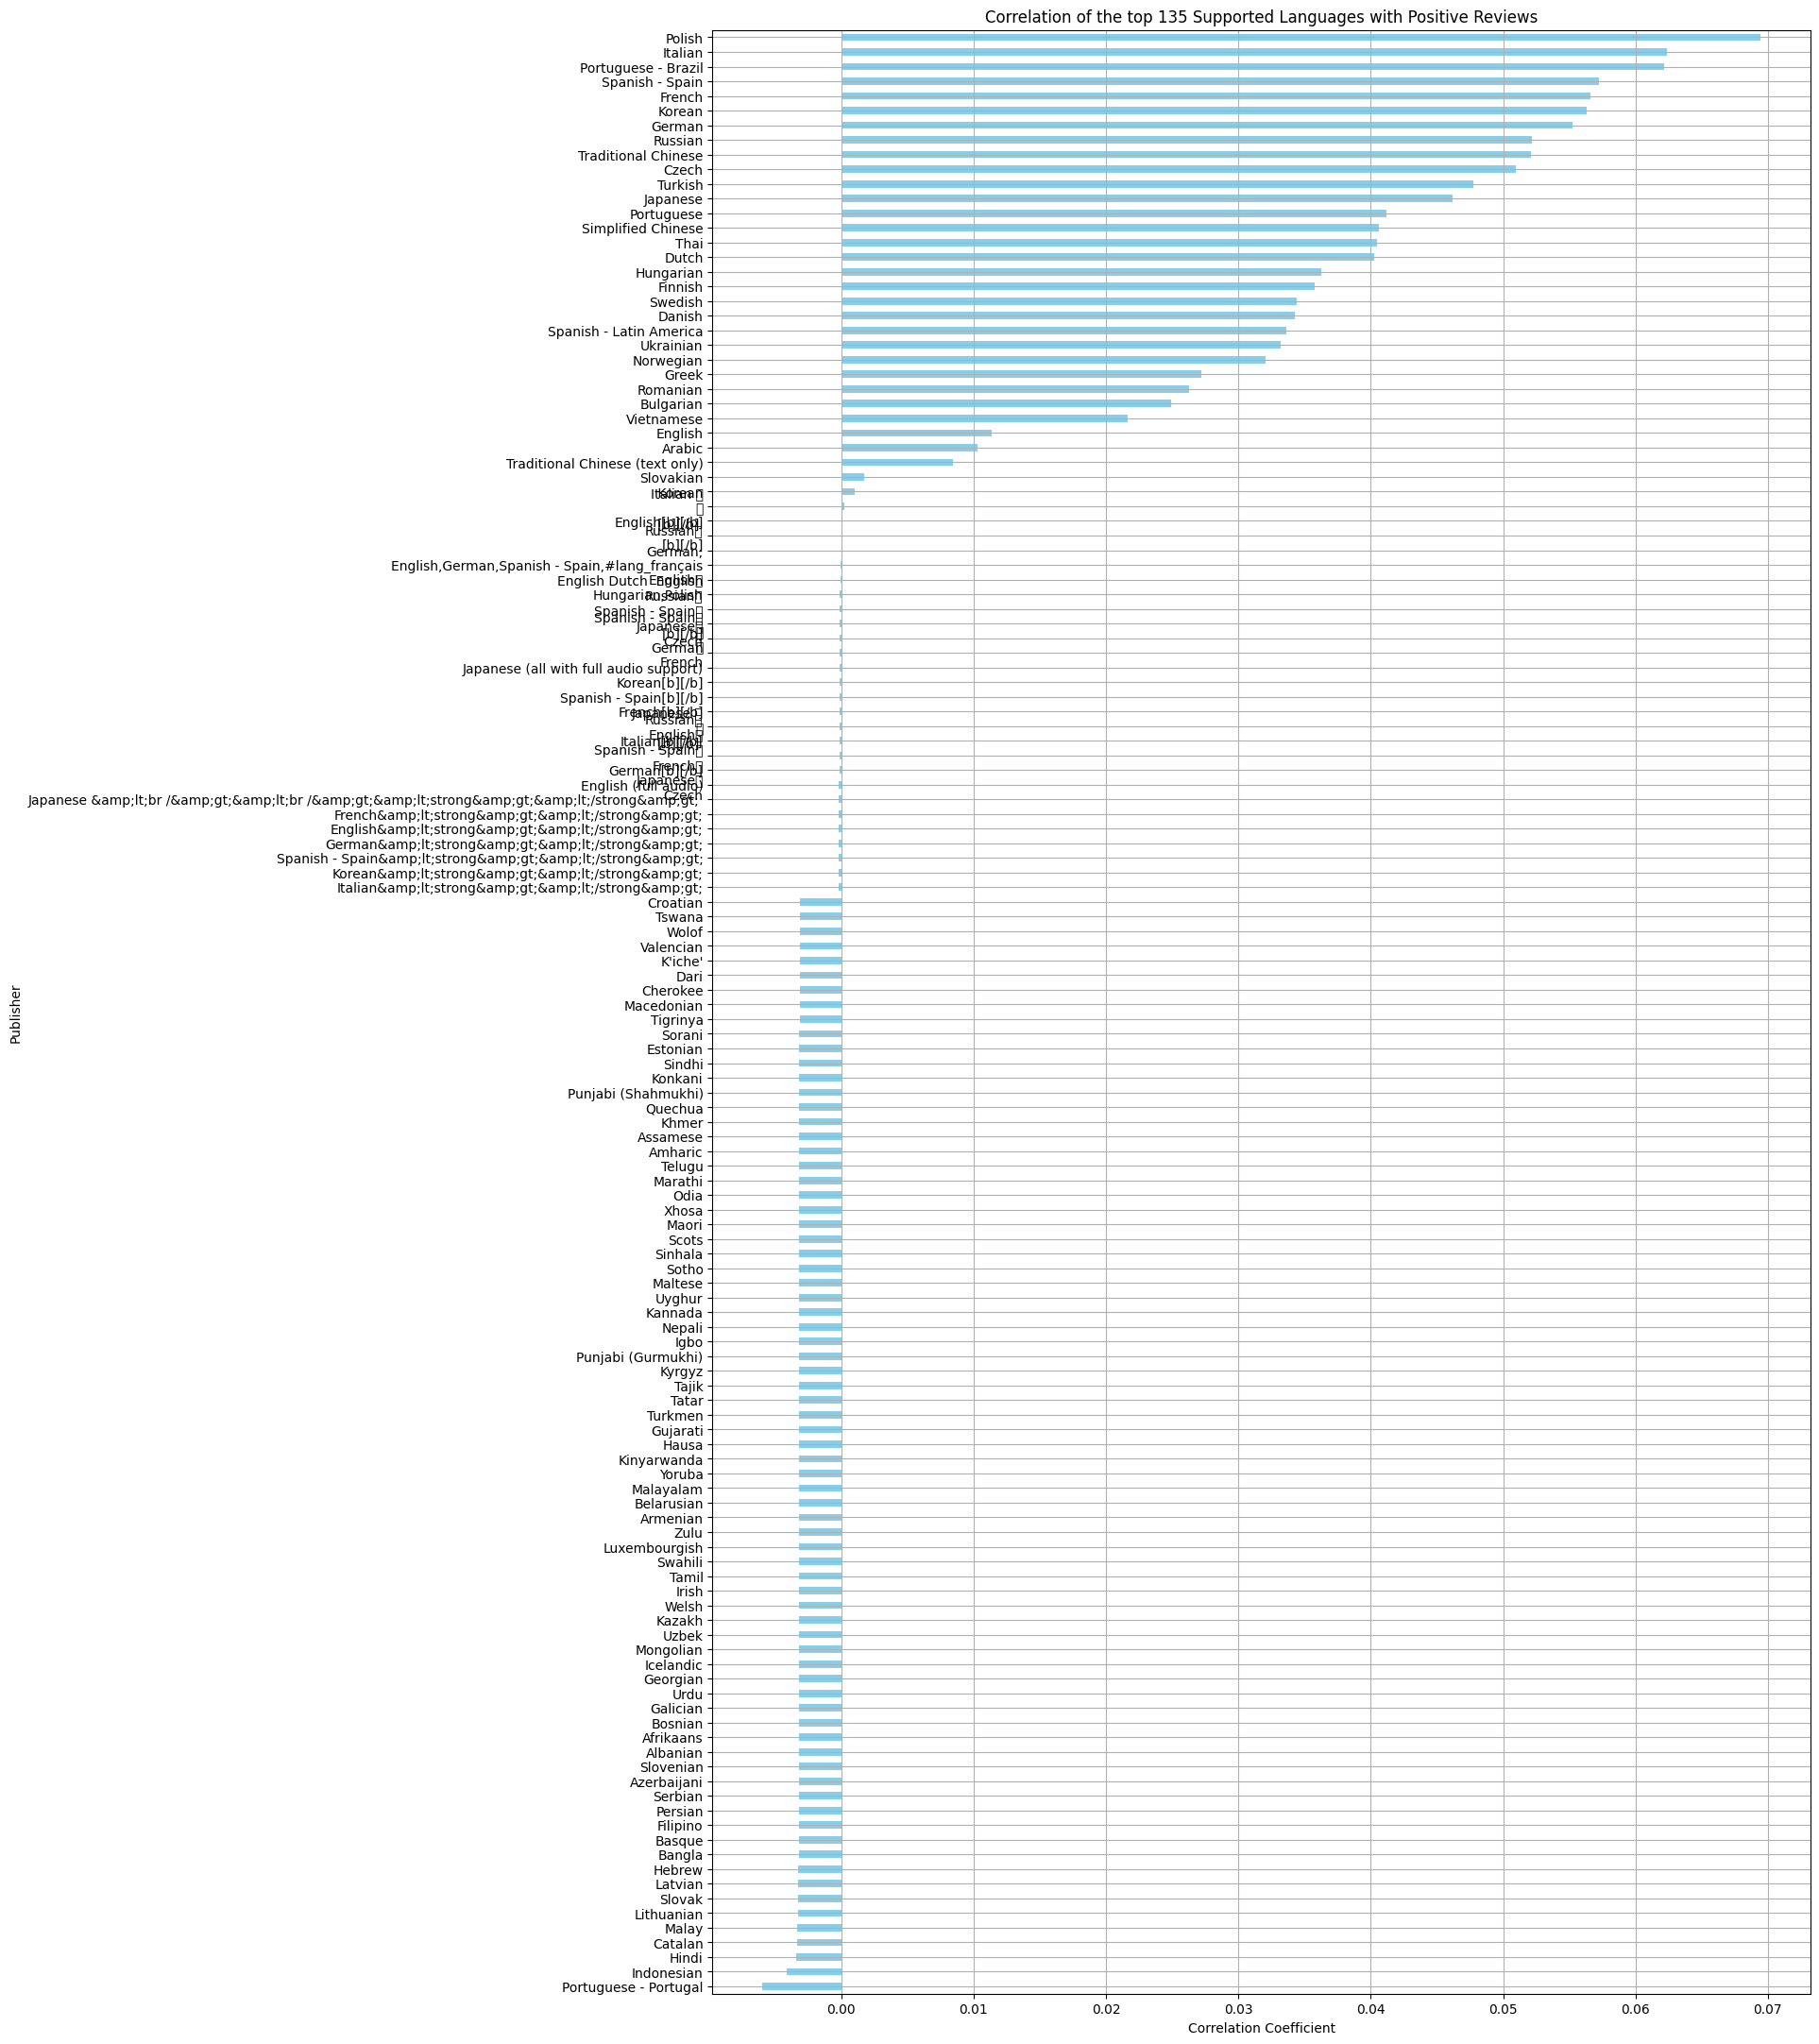

In [216]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression

print(f"Number of unique Supported Languages: {data['supported_languages'].explode().nunique()}")
LIMIT = 135

top_supported_languages = data['supported_languages'].explode().value_counts().head(LIMIT).index
data['supported_languages_filtered'] = data['supported_languages'].apply(lambda x: [i for i in x if i in top_supported_languages])

# One-hot encode the tags
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['supported_languages_filtered'])

tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Combine with positive reviews
data_encoded = pd.concat([data[['positive_reviews']], tags_df], axis=1)

# Compute correlation with positive reviews
correlations = data_encoded.corr()['positive_reviews'].drop('positive_reviews')

# "Top" meaning the amount of games that the publisher has published
print(f"\nCorrelation of the top {LIMIT} Supported Languages with Positive Reviews:\n", correlations.to_string())

# Sort and plot
plt.figure(figsize=(15, LIMIT / 5))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title(f'Correlation of the top {LIMIT} Supported Languages with Positive Reviews')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Publisher')
plt.grid(True)
plt.show()